<center><h1><strong>Data Science EDA</strong></h1><center>

This notebook contains exploratory data analysis of Data Science Roles, Skills & Salaries 2025 dataset from Kaggle (https://www.kaggle.com/datasets/sidraaazam/data-science-roles-skills-and-salaries-2025). The purpose of this analysis is for me to practice some basic EDA and Python skills with a dataset that will hopefully provide insights that inform my own self-education and job search in the field of data analytics and data science.

Here are the main questions guiding my analysis:
1. What skills are highly sought after among Data Science roles and which skills are most desired (as reflected in salaries)?
2. How are jobs and skills distributed across industries?
3. Do insights gained through this EDA provide guidance for my own skill and portfolio development?

As is my personal preference, the code contained herein is heavily editorialized with comments. The notebook will also conclude with a summary of skills, tools, and resources used.

<h2><strong>Data</strong></h2>

In [1]:
## importing modules that are probably just generically useful for most data analysis scripts.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from sklearn.linear_model import LinearRegression
from collections import Counter
import seaborn as sns
import lightgbm
from lightgbm import early_stopping
import os
import sys

## Now it's time to get that data...
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "data_science_job_posts_2025 (2).csv"

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,"sidraaazam/data-science-roles-skills-and-salaries-2025",file_path)

<h2><strong>Cleaning</strong></h2>

I'll start with salaries. After taking a look at the dataset, I've realized that salaries are all presented in '€' (thankfully).

Some are presented as single values, while others are ranges. I'd like to strip out the '€' symbols, commas, and convert ranges to averages.

I'll define a function that will clean this up for me.

In [2]:
def salary_clean(salary):
    if pd.isna(salary):
        return np.nan
    salary = salary.replace('€', '').replace(',', '').strip()
    if '-' in salary:
        low, high = salary.split('-')
        return (float(low) + float(high)) / 2
    else:
        try:
            return float(salary)
        except ValueError:
            return np.nan

## Now I'll apply this function to the 'Salary' column in the dataframe, since I'll need this cleaned version from the start.
df['Cleaned_Salary'] = df['salary'].apply(salary_clean).astype(float)

Early analysis revealed that there are three strongly outlying salaries in the dataset.
In order to avoid repeated skewing of results, I mostly worked with a filtered version of the dataset.

In [3]:
df_filtered = df[df['Cleaned_Salary'] < 600000].copy()

Similarly to the salaries, I'll need a function to clean up revenues.

This will remove the € symbol and the trailing M, T, and B characters while converting all values to floats (in billions of Euros).

In [4]:
def rev_clean(rev):
         if pd.isna(rev):
             return np.nan
         if rev in ['Public', 'Private', 'Education', 'Nonprofit']:
             return np.nan
         rev = rev.replace('€', '').replace(',', '').strip()
         if rev.endswith('B'):
             return float(rev[:-1])
         if rev.endswith('T'):
             return float(rev[:-1])*1000
         if rev.endswith('M'):
             return float(rev[:-1])/1000

## Now we'll apply the function to our filtered dataset.
df_filtered.loc[:,'Cleaned_Revenue'] = df_filtered['revenue'].apply(rev_clean).astype(float)

When looking at how seniority level affects salary, I'll lump junior + midlevel (junior) and senior + lead roles (senior) in a new Seniority_Binary field.

In [5]:
df_filtered.loc[:, 'Seniority_Binary'] = df_filtered['seniority_level'].apply(lambda x: 'junior' if x in ['junior', 'midlevel'] else 'senior' if pd.notna(x) else np.nan)

During the skills analysis, I'll need lists of the individual skills for Junior roles...

In [6]:
jr_subset = df_filtered[df_filtered['Seniority_Binary'] == 'junior']['skills'].dropna()
jr_skill_counter = Counter()
for skills in jr_subset:
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    jr_skill_counter.update(skill_list)
most_common_jr_skills = jr_skill_counter.most_common(25)

... and for Senior roles.

In [7]:
sr_subset = df_filtered[df_filtered['Seniority_Binary'] == 'senior']['skills'].dropna()
sr_skill_counter = Counter()
for skills in sr_subset:
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    sr_skill_counter.update(skill_list)
most_common_sr_skills = sr_skill_counter.most_common(25)

<h2><strong>Exploratory Data Analysis</strong></h2>

<h3>Salaries and Seniority Levels</h3>

With our cleaned up salary info, we'll first make a histogram to view the distribution of salaries.

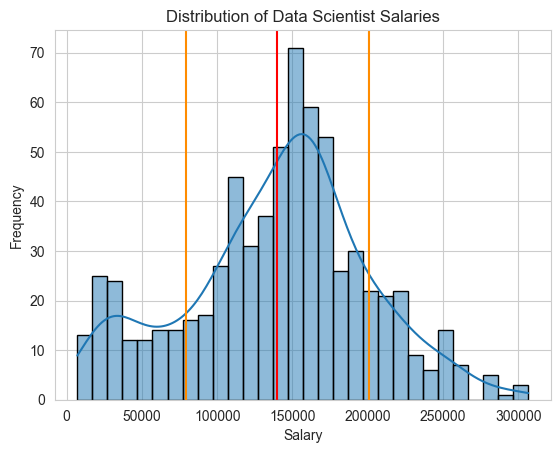

Mean Salary: 139943.8922852984
Salary Standard Deviation: 60804.30438679602


In [50]:
sal_mean=df_filtered['Cleaned_Salary'].mean()
sal_dev=df_filtered['Cleaned_Salary'].std()

sns.histplot(data=df_filtered['Cleaned_Salary'],bins=30, edgecolor='black', kde=True)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Data Scientist Salaries')
plt.grid(True)
plt.axvline(x=sal_mean, color="red")
plt.axvline(x=sal_mean+sal_dev, color="darkorange")
plt.axvline(x=sal_mean-sal_dev, color="darkorange")
plt.show()  
print(f"Mean Salary: {sal_mean}")
print(f"Salary Standard Deviation: {sal_dev}")

Next, let's see what the distribution of salaries looks like when broken down by seniority level.

We'll look at this one with a boxplot.

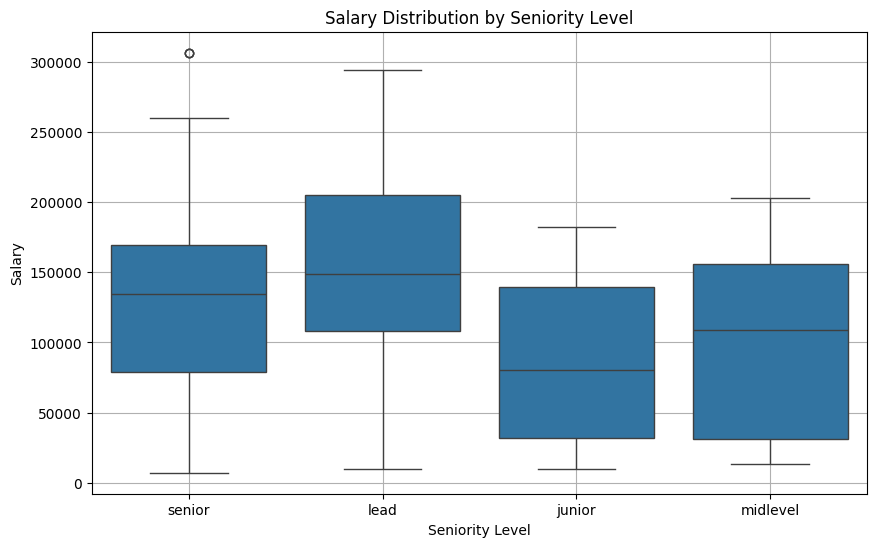

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='seniority_level', y='Cleaned_Salary', data=df_filtered)
plt.xlabel('Seniority Level')
plt.ylabel('Salary')
plt.title('Salary Distribution by Seniority Level')
plt.grid(True)
plt.show()

The boxplot suggests that "junior" and "midlevel" might not really be meaningful distinctions.

We can examine this a bit further by making histograms of salaries by seniority level and viewing them all together on one plot.


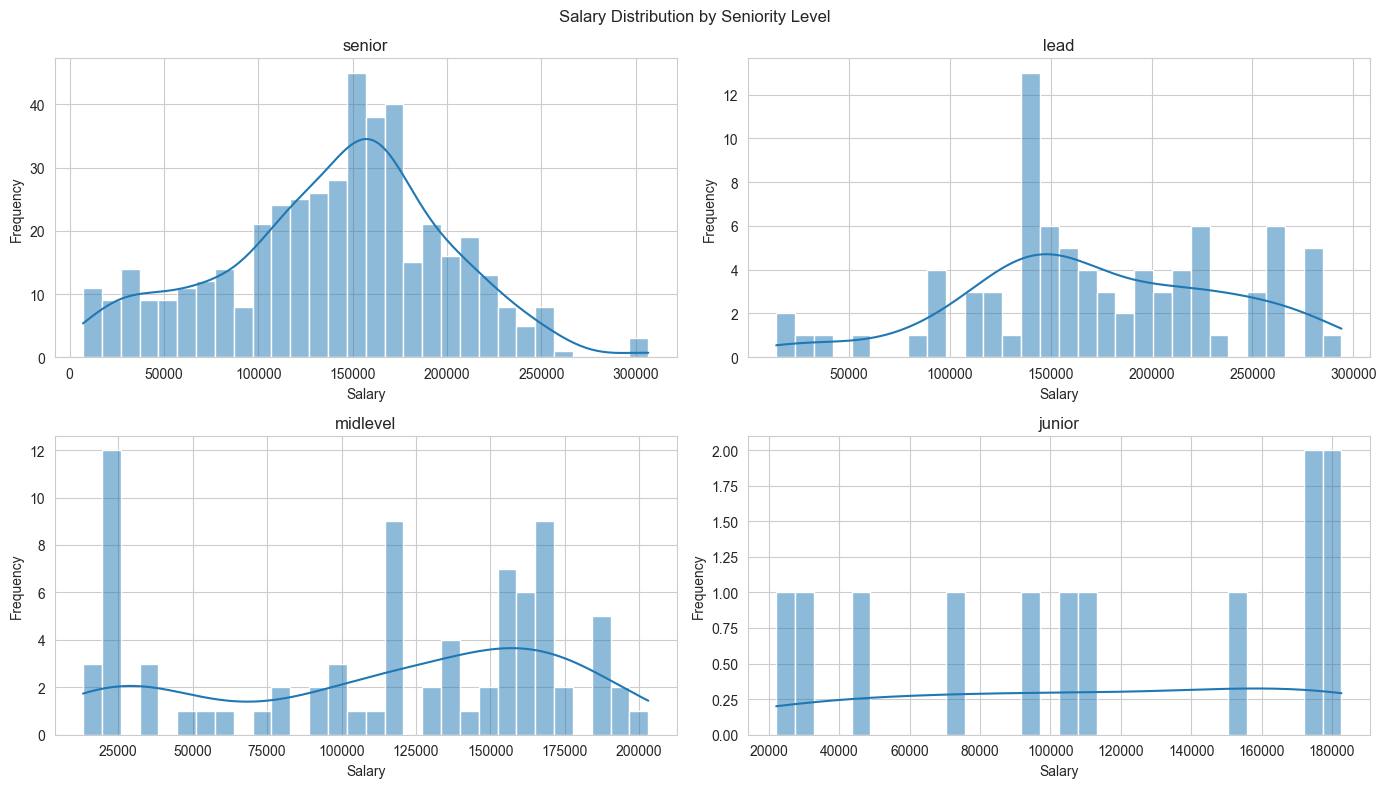

In [47]:
experience_levels = df_filtered['seniority_level'].dropna().unique()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), sharey=False)
sns.set_style('whitegrid')

axes = axes.flatten()
for ax, level in zip(axes, experience_levels):
    sns.histplot(data=df_filtered[df_filtered['seniority_level'] == level], x='Cleaned_Salary', color='C0', bins=30, kde=True, ax=ax, zorder=2)
    ax.set_axisbelow(True)
    ax.grid(True)
    ax.set_title(level)
    ax.set_xlabel('Salary')
    ax.set_ylabel('Frequency')

plt.suptitle('Salary Distribution by Seniority Level')
plt.tight_layout()
plt.show()

These plots make it clearer that "junior" has far fewer records than the other categories, and distributions are not exactly normal.

Let's see how the salary distribution changes when we consider the Seniority_Binary generated earlier.

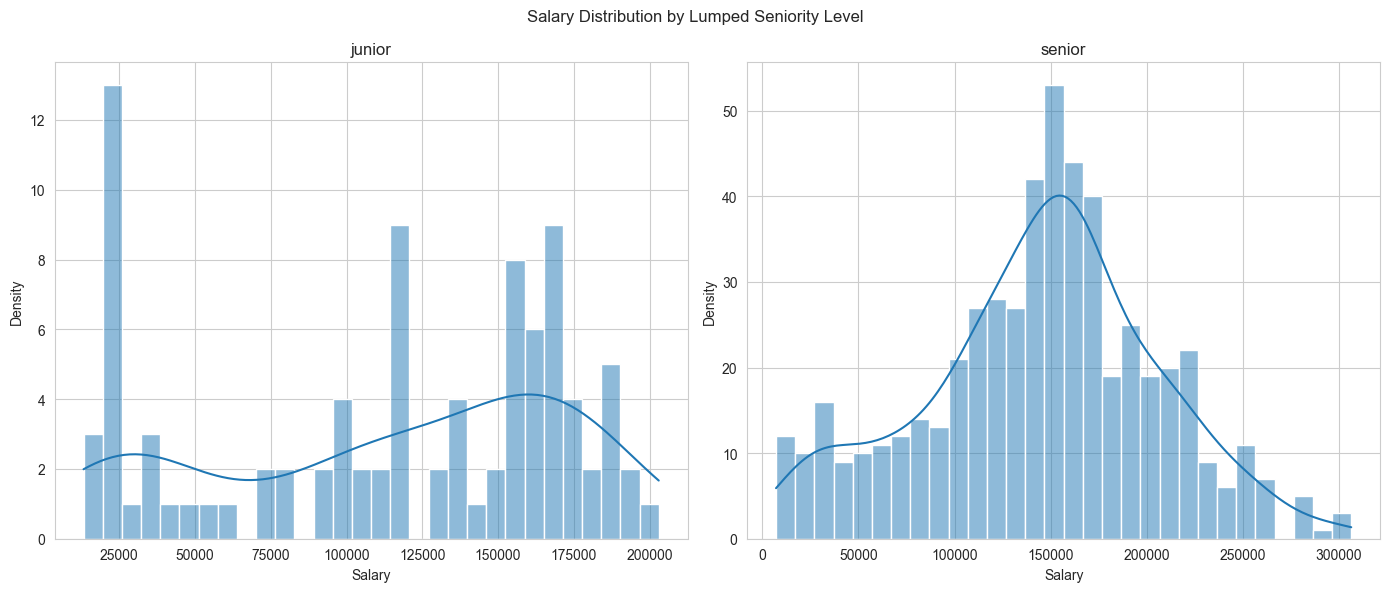

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=False)
axes = axes.flatten()
for ax, level in zip(axes, ['junior', 'senior']):
    sns.histplot(data=df_filtered[df_filtered['Seniority_Binary'] == level], x='Cleaned_Salary', bins=30, kde=True, ax=ax)
    ax.set_title(level)
    ax.set_xlabel('Salary')
    ax.set_ylabel('Density')

plt.suptitle('Salary Distribution by Lumped Seniority Level')
plt.tight_layout()
plt.show()

These are actually pretty interesting results. We can pretty clearly see that salaries in the "junior" category is not normally distributed.


The "Senior" category is closer to normal, but still has a bit of a right skew.


I'll be curious to see if particular skills are associated with identifiable distribution patterns...


<h3>Skills Analysis</h3>

To get started, I'll need to learn something about what skills are listed.

I took a look at the skills data, and I'm seeing that most entries are comma-separated lists of skills.

What I'd like to do is understand which individual skills appear most often for 'junior' roles and 'senior' roles.

I'll compare the top skills for both levels.

In [58]:
print('\nTop Skills for Junior and Senior DS Roles')
print(f"{'No.':<5} {'Junior Skill':<20} {'Count':<7} {'Senior Skill':<20} {'Count':<7}")
print("-" * 70)
for i in range(max(len(most_common_jr_skills), len(most_common_sr_skills))):
    jr_skill, jr_count = most_common_jr_skills[i]
    sr_skill, sr_count = most_common_sr_skills[i]
    print(f"{i+1:<5} {jr_skill:<20} {jr_count:<7} {sr_skill:<20} {sr_count:<7}")


Top Skills for Junior and Senior DS Roles
No.   Junior Skill         Count   Senior Skill         Count  
----------------------------------------------------------------------
1     python               115     python               522    
2     machine learning     106     machine learning     473    
3     sql                  73      sql                  367    
4     r                    53      r                    289    
5     aws                  29      aws                  187    
6     spark                26      deep learning        153    
7     deep learning        24      tensorflow           147    
8     database             21      azure                140    
9     tensorflow           17      spark                133    
10    pytorch              15      pytorch              133    
11    azure                13      tableau              103    
12    tableau              12      gcp                  95     
13    hadoop               10      scikit-learn       

For the most part, these lists are in agreement. I'm honestly a little surprised not to see more differentiation.

I think what would be interesting is to see which skills are associated with higher salaries within each experience level.

Let's start with junior roles.

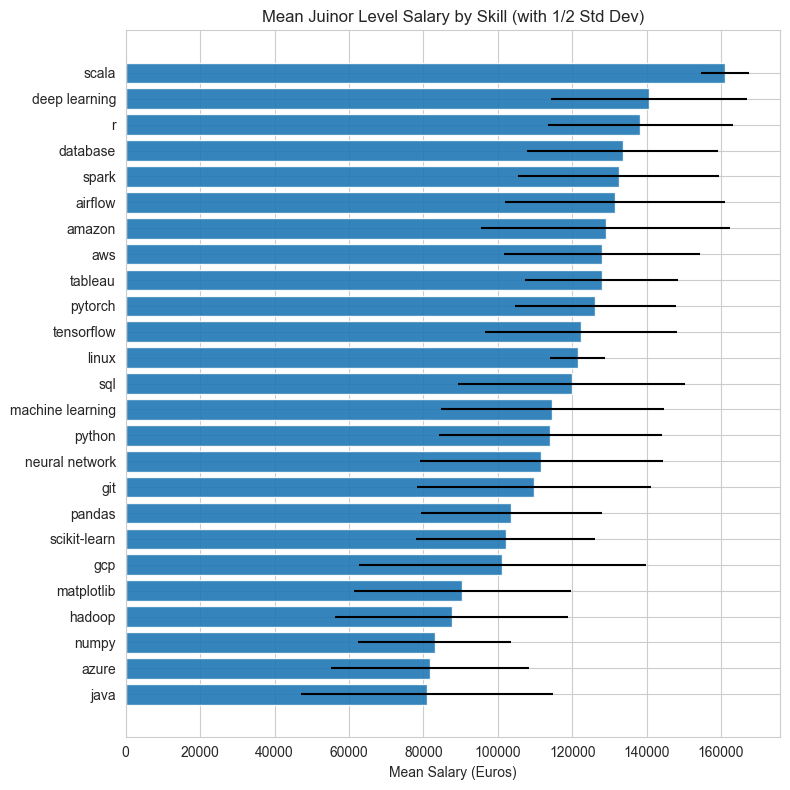

In [51]:
## Create a dictionary where each skill maps to a list of salaries for junior roles requiring that skill.
jr_skill_salary = {}
for skills, salary in zip(df_filtered[df_filtered['Seniority_Binary'] == 'junior']['skills'].dropna(), df_filtered[df_filtered['Seniority_Binary'] == 'junior']['Cleaned_Salary'].dropna()):
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    for skill in skill_list:
        if skill not in jr_skill_salary:
            jr_skill_salary[skill] = []
        jr_skill_salary[skill].append(salary)

## Now let's get some summary stats for each skill.
jr_skill_salary_summary = {skill: (np.mean(salaries), np.median(salaries), np.std(salaries), len(salaries)) for skill, salaries in jr_skill_salary.items() if len(salaries) >= 2}
jr_skill_salary_summary_sorted = sorted(jr_skill_salary_summary.items(), key=lambda x: x[1][0], reverse=True)

## Now we have a dictionary containing skills and summary stats, sorted by mean salary.
## Let's print out a table with the top 25 skills and their associated salary stats.
# print('\nJunior Level DS Skills and Salary Stats')
# print(f"{'No.':<5} {'Skill':<20} {'Mean Salary':<15} {'Median Salary':<15} {'Std Dev':<10} {'Count':<7}")
# print("-" * 80)
# for i, (skill, (mean_salary, median_salary, std_dev, count)) in enumerate(jr_skill_salary_summary_sorted[:25]):
#     print(f"{i+1:<5} {skill:<20} {mean_salary:<15.2f} {median_salary:<15.2f} {std_dev:<10.2f} {count:<7}")

jr_skills_df = pd.DataFrame.from_dict(jr_skill_salary_summary, orient='index', columns=['mean_salary','median_salary','std_dev','count']).reset_index().rename(columns={'index':'skill'})

jr_skills_plot = jr_skills_df.sort_values('mean_salary', ascending=True)

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(jr_skills_plot['skill'], jr_skills_plot['mean_salary'], xerr=(jr_skills_plot['std_dev']/2), color='C0', alpha=0.9)
ax.set_xlabel('Mean Salary (Euros)')
ax.set_title('Mean Juinor Level Salary by Skill (with 1/2 Std Dev)')
plt.tight_layout()
plt.show()
    

One thing I'm noticing is that these standard deviations are very high.

What this tells me is that the roles I've broadly classified as "junior" probably represent a wide range of actual experience levels.


My theory at this point would be that the top skills are really just the "tools of the trade" and that, for these junior roles at least,
there's unlikely to be a strong correlation between specific skills and salary. Also, pay for some of these jobs is shockingly low.
At some point later I might want to see if the covariance of skill pairs for some of these tops skills is better correlated with salary.

For now, I'll take a look at senior roles next and see if there's more differentiation there.

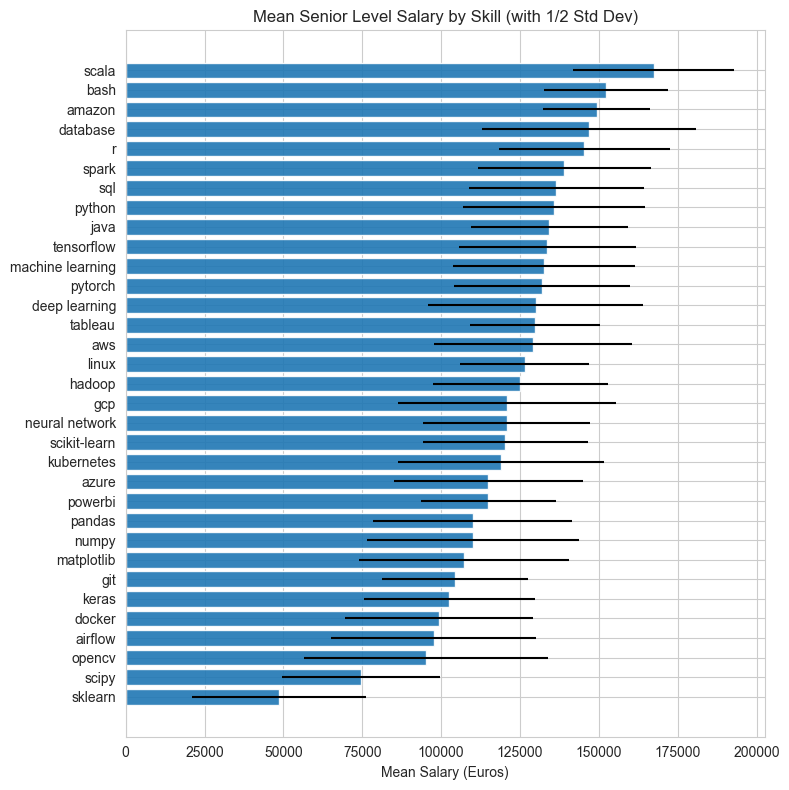

In [52]:
sr_skill_salary = {}
for skills, salary in zip(df_filtered[df_filtered['Seniority_Binary'] == 'senior']['skills'].dropna(), df_filtered[df_filtered['Seniority_Binary'] == 'senior']['Cleaned_Salary'].dropna()):
    skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
    for skill in skill_list:
        if skill not in sr_skill_salary:
            sr_skill_salary[skill] = []
        sr_skill_salary[skill].append(salary)


sr_skill_salary_summary = {skill: (np.mean(salaries), np.median(salaries), np.std(salaries), len(salaries)) for skill, salaries in sr_skill_salary.items() if len(salaries) >= 2}
sr_skill_salary_summary_sorted = sorted(sr_skill_salary_summary.items(), key=lambda x: x[1][0], reverse=True)

# print('\nSenior Level DS Skills and Salary Stats')
# print(f"{'No.':<5} {'Skill':<20} {'Mean Salary':<15} {'Median Salary':<15} {'Std Dev':<10} {'Count':<7}")
# print("-" * 80)
# for i, (skill, (mean_salary, median_salary, std_dev, count)) in enumerate(sr_skill_salary_summary_sorted[:25]):
#     print(f"{i+1:<5} {skill:<20} {mean_salary:<15.2f} {median_salary:<15.2f} {std_dev:<10.2f} {count:<7}")


sr_skills_df = pd.DataFrame.from_dict(sr_skill_salary_summary, orient='index', columns=['mean_salary','median_salary','std_dev','count']).reset_index().rename(columns={'index':'skill'})

sr_skills_plot = sr_skills_df.sort_values('mean_salary', ascending=True)

fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(sr_skills_plot['skill'], sr_skills_plot['mean_salary'], xerr=(sr_skills_plot['std_dev']/2), color='C0', alpha=0.9)
ax.set_xlabel('Mean Salary (Euros)')
ax.set_title('Mean Senior Level Salary by Skill (with 1/2 Std Dev)')
plt.tight_layout()
plt.show()


Ok, now we're getting somwhere.

Scala is obviously showing itself as a high-value skill. My bet is that this has to do with who is hiring.
That is to say, it's probably big companies who are utilizing Scala for large dataset processing, automations, etc.

I'll have to do more reasearch on that (and see if I can find a way to work with Scala for a project in my portfolio),
but the language itself doesn't really look to be that different from Python or R for data science tasks. If a company has already sunk
significant resources into Scala implementation, though, that would explain why they are willing to pay a premium for it.

Same is likely the case for Spark and some the other big data skills we're seeing here like 'amazon' and 'aws' that speak to the (cloud) infrastucture that companies have in place.

Interestingly, bash shows up in the senior skills, but not the junior skills. I would guess this is because senior roles are expected to own
more of the end-to-end data pipeline, which often involves some bash scripting for OS-level automations.

I'm also somewhat surprised not to see more generic skills (communication, teamwork, agile, MS Office, etc.).
Maybe these things aren't as necessary for these roles, as they might not be client-facing? or maybe they just assume everyone has them or they are more trainable on the job than technical skills?

<h3>Salary Distribution by Job Title</h3>

Now let's look at how salary distribution varies with job title.

The dataset contains only a single "data analyst" salary, and just three "data engineer" salaries. The single "data analyst" listing is filtered out for its very high salary.

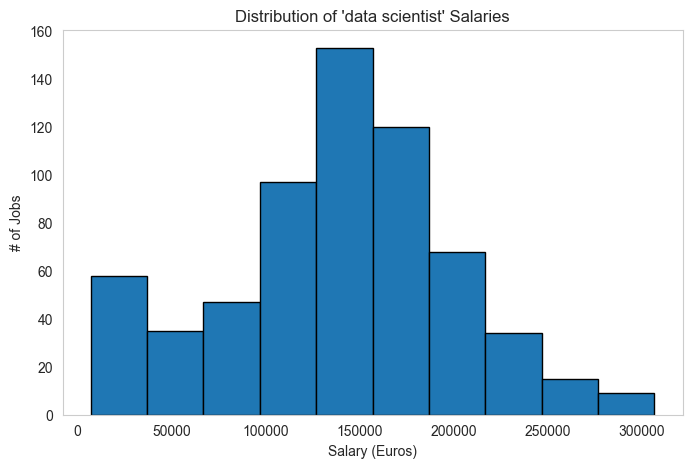

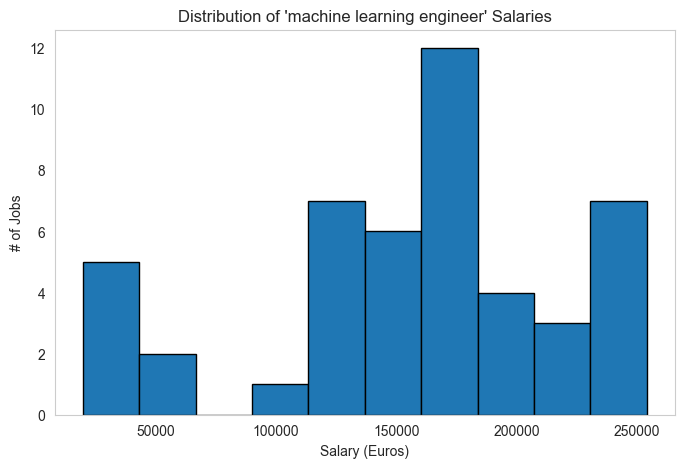

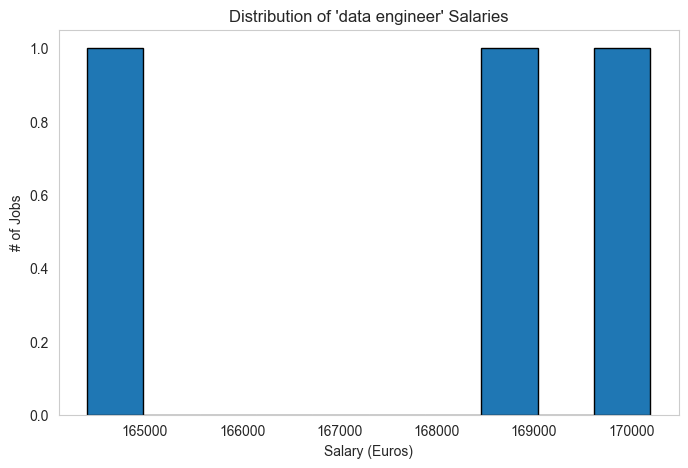

In [53]:
title_list = df_filtered['job_title'].dropna().unique()
title_counts = df_filtered['job_title'].dropna().value_counts()

for title in title_list:
        plt.figure(figsize=(8, 5))
        df_filtered[df_filtered['job_title']==title]['Cleaned_Salary'].plot.hist(bins=10, edgecolor = 'black')
        plt.xlabel('Salary (Euros)')
        plt.ylabel('# of Jobs')
        plt.title(f"Distribution of '{title}' Salaries")
        plt.grid(False)
        plt.show()

Ok, we have an idea of the range of salaries and how they are distributed by job title and seniority level. We also have an idea of the skills most commonly expected, and how they relate to mean salary.

I think maybe the next step should be to see how salaries and skills vary by industry.

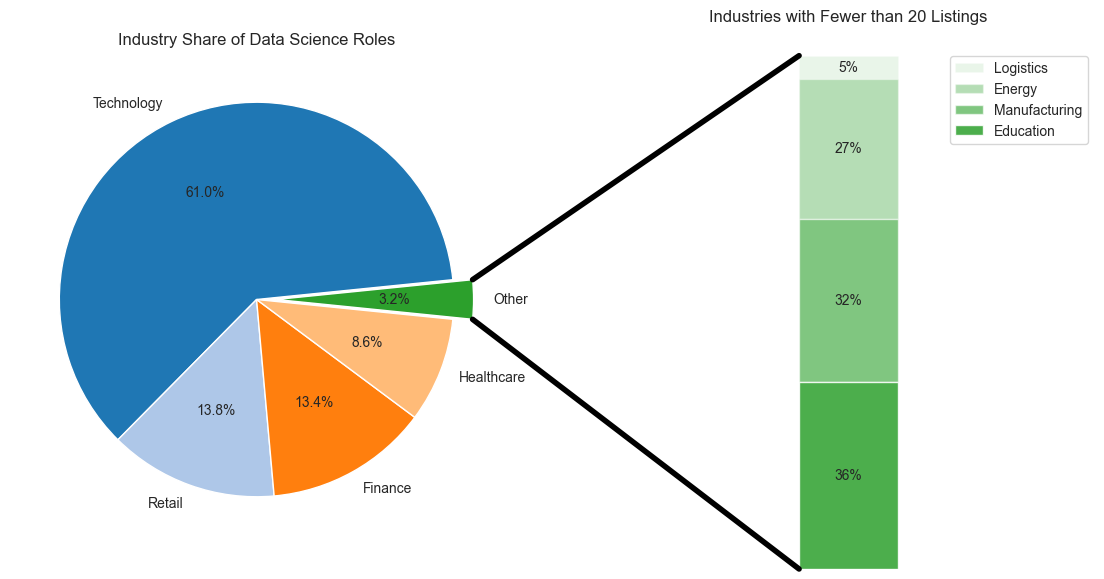

In [54]:
industries = df_filtered['industry'].dropna().unique()
industry_counts = df_filtered['industry'].dropna().value_counts()

## This time, I'll make a pie chart of industries represented in the dataset, combining industries with fewer than 20 listings into an "Other" category.
## Then, I'll add a bar of the "Other" slice so we can see how the smaller industries contribute without making the pie chart unreadable.

big_ind = industry_counts[industry_counts >= 20]
lil_ind = industry_counts[industry_counts < 20]
big_ind['Other'] = lil_ind.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

## pie chart params
pie_labels = big_ind.index
pie_sizes = big_ind.values
colors = plt.cm.tab20.colors[:len(pie_labels)]
explode = [0.1 if size == big_ind['Other'] else 0 for size in pie_sizes]
angle = 180*(pie_sizes.min()/sum(pie_sizes))
## took me a while to understand this next part, but this will capture the slices from the .pie() call and junk the other outputs into var '_'.
wedges, *_ = ax1.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', startangle=angle, colors=colors, explode=explode)
ax1.set_title('Industry Share of Data Science Roles')

## bar chart params
bar_labels = lil_ind.index
bar_sizes = [v / sum(lil_ind.values) for v in lil_ind.values]
bottom = 1
width = 0.2

## stack bars to match legend order
for s, (height, label) in enumerate(reversed([*zip(bar_sizes, bar_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, label=label, color='C2', alpha = 0.1 + 0.25 * s)
    ## create bars
    ax2.bar_label(bc, labels = [f"{(height):.0%}"], label_type = 'center')

## bar chart info
ax2.set_title('Industries with Fewer than 20 Listings')
ax2.legend(loc = 'best', bbox_to_anchor=(1, 0.965))
ax2.axis('off')
ax2.set_xlim(-2.5*width, 2.5*width)

## Now we draw some lines connecting the pie to the bar chart.
## Theta values here represent the ends of the curve of the "Other" wedge that we'll be exploding and making a bar for.
theta1, theta2 = wedges[4].theta1, wedges[4].theta2
center, r = wedges[4].center, wedges[4].r
bar_height = sum(bar_sizes)

## draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

## draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

That ended up being a pretty good looking plot. We're seeing that tech dominates the field, followed by finance, retail, and healthcare.

What could explain this distribution? Tech would obviously be the industry most burdened with large datasets, so that makes sense.

Finance would also be a data-heavy industry, with the added pressure to derive valueable insights from data either for driving trade decisions,
risk management, fraud detection, or customer insights. Retail would also have a lot of data, especially e-commerce, and an interest in converting
that data into customer insights.

Healthcare is interesting, becuase I would assume that it's representation here is more about the similar pressures
on the industry to the others listed (lots of data, lots of customers, high cost of operation drives an emphasis on cost reduction and efficiency),
rather than a belief among healthcare companies that data science has a major role to play in directing care or R&D.

Next, I'll take a look at which skills are most commonly requested by industry.

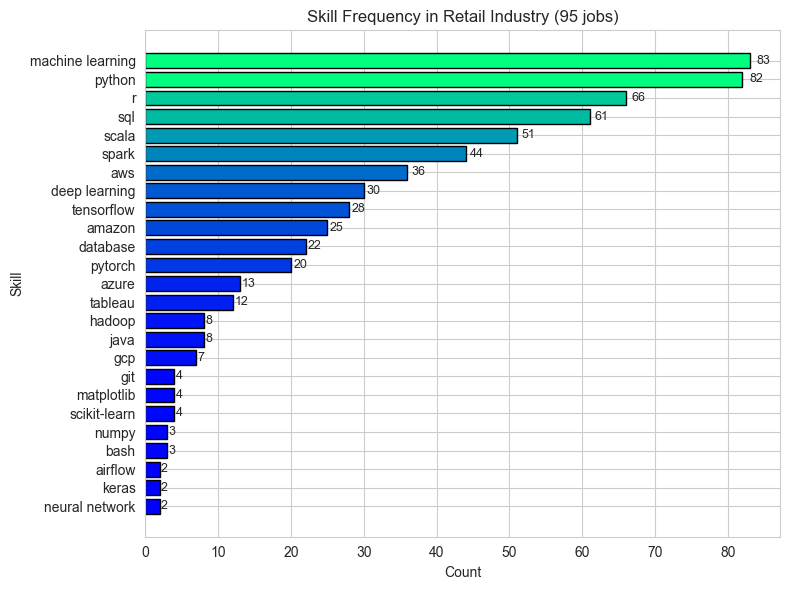

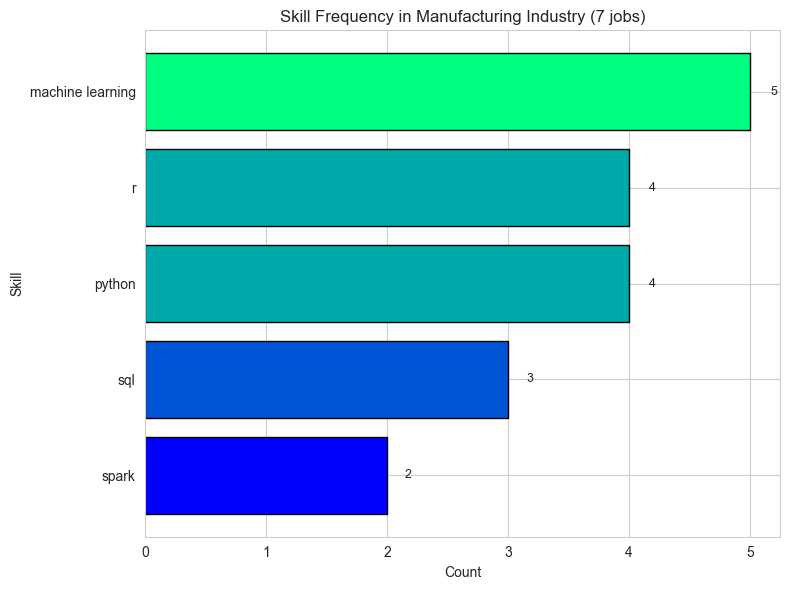

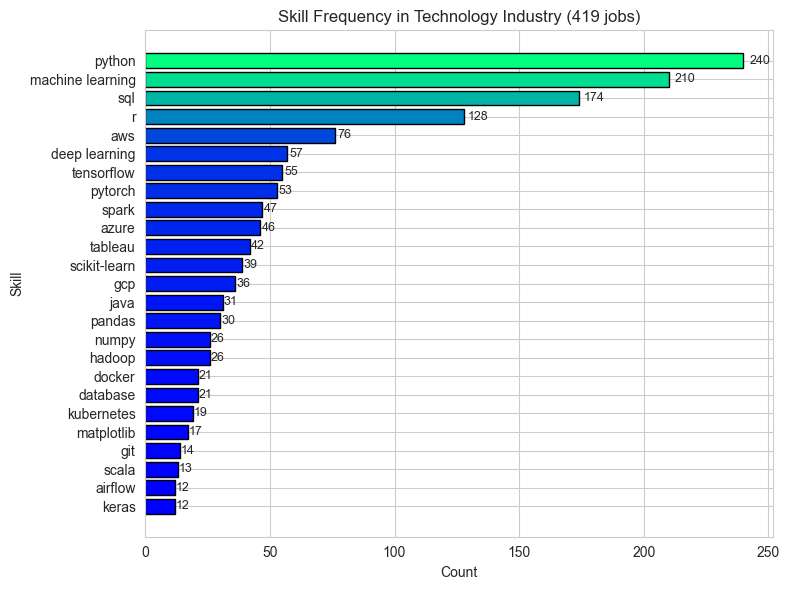

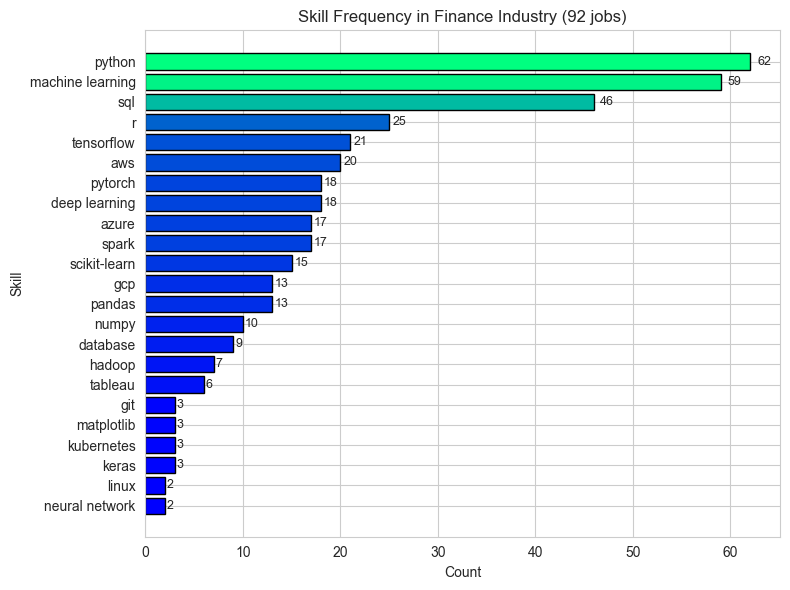

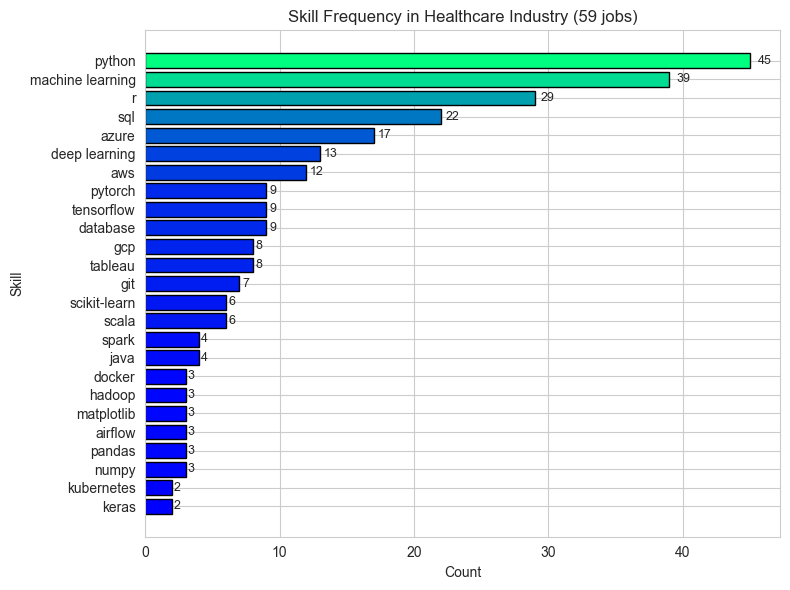

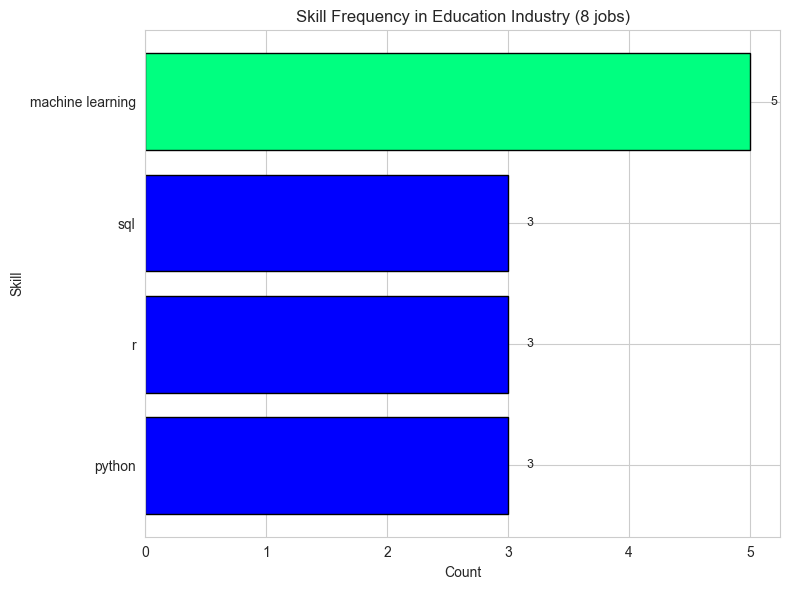

In [59]:
industry_skill_counter = {industry: Counter() for industry in industries}
for industry in industries:
    for skills in df_filtered[df_filtered['industry'] == industry]['skills'].dropna():
        skill_list = [skill.strip(" []'\"").lower() for skill in skills.split(',') if skill.strip(" []'\"")]
        industry_skill_counter[industry].update(skill_list)
most_common_industry_skills = {industry: counter.most_common(25) for industry, counter in industry_skill_counter.items()}

for industry, skills in most_common_industry_skills.items():
    if industry not in ['Logistics', 'Energy']:
        frequent_skills = [(skill, count) for skill, count in skills if count > 1]
        skill_list, counts = zip(*frequent_skills)
        skill_prop = np.array(counts)/(industry_counts[industry])

        norm = plt.Normalize(skill_prop.min(), skill_prop.max())
        cmap = plt.cm.winter
        colors = cmap(norm(skill_prop))

        fig, ax = plt.subplots(figsize =(8, 6))
        ax.barh(skill_list, counts, color=colors, edgecolor='black')
        ax.set_title(f'Skill Frequency in {industry} Industry ({industry_counts[industry]} jobs)')
        ax.set_xlabel('Count')
        ax.set_ylabel('Skill')
        ax.invert_yaxis()
        for i, (skill, count) in enumerate(zip(skills, counts)):
            ax.text(count + ((0.01*count)+0.125), i, str(count), va='center', fontsize=9)
        plt.tight_layout()
        plt.show()

So, the most interesting thing I'm noticing here is Scala only appears as a top-ten skill in retail.
Explanding our view to the top 25 skills, Scala shows up in healthcare, tech, and energy as well.

Another intersting data point here is where we see deep learning as a major skill. This represents a real differentiation of the types
of data and insights sought by each industry. Retail, finance, tech, and healthcare all make sense here, as we can pretty easily intuit
the types of unstructured data (images, text, video, audio) that these industries would be handling, and how they might benefit from deep learning.

Although not as directly insightful at the scale of industry hiring trends, we can understand a difference in the types of roles being hired for
where we see skills like Tableau and Power BI. These are more business-intelligence oriented skills, suggesting roles that are more focused
on presenting data insights to business stakeholders, rather than or in addition to building data products or automations. We see these skills represented in tech, finance, healthcare, and retail.

Appart from that, we're mostly seeing the same skills and the same rankings for each industry.
The big takeaway here is probably that if you want to get a job as a data scientist you should know python, SQL, machine learning, and R.
Some familiarty with big data tools and infrastructure (Hadoop, Spark, AWS, etc.) is probably a good idea, and some familiarity with cloud computing (read: AWS) could be helpful as well.
Depending on the role, some knowledge of deep learning and/or business intelligence tools may also be desirable. Probably sufficient demonstration of visualization skills in other domains could satisfy the requirement for these skills, though.

<h3>Revenues & Salaries</h3>

Now I want to look at the association of company revenue and salary.

Where both Cleaned_Salary and Cleaned_Revenue (created during data cleaning) are not null, I'll create a scatterplot of the relationship between salary and revenue.
To do that, I need a version of the dataframe that only has records where both values are not null.

In [60]:
df_revclean = df_filtered.dropna(subset=['Cleaned_Revenue', 'Cleaned_Salary']).copy()

The cleaned revenues need to be in a 2D array for the .fit() and .score() functions that we'll use for our linear regression and to generate an R-squared value, respectively.

In [61]:
X = df_revclean['Cleaned_Revenue'].values.reshape(-1,1)
Y = df_revclean['Cleaned_Salary'].values

Now we create the scatter plot and plot a trend line. 

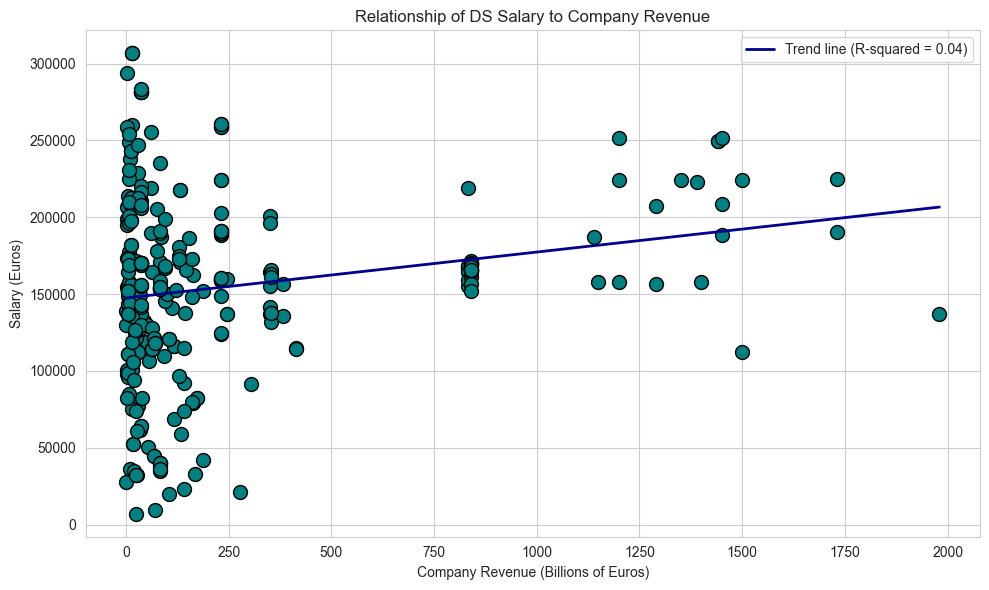

In [62]:
model = LinearRegression()
model.fit(X, Y)
## Get an R-squared value by predicting values based on trend line and compare to actual salaries.
## Like with X above, rev_range needs to be a 2D array for .predict()
rev_range = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
pred_sal = model.predict(rev_range)
r_squared = model.score(X, Y)
## create the scatter plot and plot the trend line labeled with R-squared value
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(df_revclean['Cleaned_Revenue'], df_revclean['Cleaned_Salary'], color='teal', edgecolor='black', s=100)
ax.plot(rev_range, pred_sal, color='darkblue', linewidth=2, label=f'Trend line (R-squared = {r_squared:.2f})')
ax.grid(True)
ax.legend()
plt.title('Relationship of DS Salary to Company Revenue')
plt.xlabel('Company Revenue (Billions of Euros)')
plt.ylabel('Salary (Euros)')
plt.tight_layout()
plt.show(block=False)

From this plot we see that company revenue is not at all a good predictor of DS role salaries. The smallest companies in terms of revenue
have some of the highest salaries in the dataset, and while the trend line suggests that bigger companies hire at slightly higher salaries,
the R-squared value tells us that this association is extremely weak in our dataset. This shows a couple of interesting things when taken
together with our previous insights: 

First, there are probably a good number of tech start-ups who are willing to pay a real premium for a 
skilled data science professional. 

Second, just because a company makes a lot of money, it does not mean that an applicant can expect a much
higher salary than they would receive from a smaller one. 

There is a clear pattern of higher variability among salaries at smaller companies, so that may be an important point of consideration for the applicant.

<h1><strong>Modeling: Expected Salary Based on Applicant's Criteria</strong></h1>

What I'll do with this section is create a modeling application that will allow the user (a prospective DS job applicant) to enter their level of experience, skills, the industry they are applying to, intended position (job title), and work type (on-site, hybrid, or remote) and predict their salary. This is a personal experiment that is, frankly, quite a bit out of my depth and experience, but hopefully I'll be able to put together something that at least functions (read: takes inputs and gives outputs). My goal with this is skill aqcuisition moreso than actual predictive power.

This was assembled largely with suggested structure and functions as recommended by Copilot. After extensive debugging and multiple attempts to improve marginal coverage with conformalized quantile regression (CQR) and cross-conformal quantile regression (CCQR), the below is the best performing iteration of the model I produced. By and large, quantile regression provided no benefit to performance of the model, and improvements from the initial version came primarily through optimization of LGBMRegressor parameters. I'll provide my thoughts on explanations for this in the conclusions section of this notebook.

In [63]:
# Standard imports
import re
import json
import joblib

# Modeling / preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Interpretability
import shap

# For reproducibility
RANDOM_STATE = 69 # funny number


<h2>Cleaning</h2>

In [64]:
## in addition to the cleaned salaries and seniority binary, the model will want a skills field with the skill lists parsed out. We'll define another function for that.

def parse_skills(skills_raw):
    if pd.isna(skills_raw):
        return ""
    s = str(skills_raw).lower()
    s = s.replace(';', ',').replace('|', ',')
    tokens = [t.strip(" []'\"").strip() for t in s.split(',') if t.strip()]
    return " | ".join(sorted(set(tokens)))  # space-separated for TF-IDF

df_filtered = df_filtered[df_filtered['status'].notna()]
df_filtered['skills_parsed'] = df_filtered['skills'].apply(lambda x: parse_skills(x))
df_filtered['work_type'] = df_filtered['status'].str.lower().replace({'on-site':'onsite'})


<h2>Model Training</h2>

In [65]:
## we'll start by making a copy of the data frame for the model
df_model = df_filtered.dropna(subset=['Cleaned_Salary', 'Seniority_Binary', 'job_title']).copy()

df_model['log_salary'] = np.log1p(df_model['Cleaned_Salary'])

## This will create training and testing subsets from our dataframe, with 20% of records reserved for testing.
train_df, test_df = train_test_split(df_model, test_size=0.2, stratify=df_model['Seniority_Binary'], random_state=RANDOM_STATE)
## Then we create the actual training and testing variables.
X_train = train_df[['Seniority_Binary','skills_parsed','job_title','industry','work_type']]
y_train = train_df['log_salary']
X_test = test_df[['Seniority_Binary','skills_parsed','job_title','industry','work_type']]
y_test = test_df['log_salary']


<h2>Feature Pipeline</h2>

In [66]:
# Categorical columns
cat_cols = ['Seniority_Binary','work_type','industry', 'job_title']

# Text column
def skill_tokenizer(text):
    return [t.strip().lower() for t in text.split('|') if t.strip()]


skill_vectorizer = CountVectorizer(tokenizer=skill_tokenizer, min_df=4)

## Transformers
## one-hot encoding will convert categorical values into simple binary values in a sparse matrix
cat_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

## preprocessor will apply our transformers to the selection criteria
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_ohe, cat_cols),
    ('skills', skill_vectorizer, 'skills_parsed'),
], remainder='drop', verbose=False)


<h2>Baseline Model</h2>

The model used in this case is Ridge, a linear regression model that uses L2 normalization, which applies a regularization rate coefficient to the model complexity so feature weights
are penalized according to their relative square values. This will provide a baseline state for comparison of the quantile (LightGBM) model, and I believe this is a good option as
the L2 normalization should reduce variance and stabilize predictions when there is high correlation between independent variables, as is very likely to be the case for this model.

In [67]:
baseline_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

## .fit() learns the parameters of our transformer as applied to our data
baseline_pipeline.fit(X_train, y_train)
y_pred_log = baseline_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

print("Baseline MAE (Euros):", mean_absolute_error(y_true, y_pred))
print("Baseline RMSE (Euros):", root_mean_squared_error(y_true, y_pred))
print("R2 (log):", r2_score(y_test, y_pred_log))
# Save pipeline
joblib.dump(baseline_pipeline, r"C:\RepoClones\PythonPractice\DSJobs\models\baseline_ridge_pipeline.joblib")

## save our dataframe to be referenced by the streamlit app later. IDK if this is really the best place to do this, but I believe at this point we're done modifying the data frame
df_filtered.to_csv(r"C:\RepoClones\PythonPractice\DSJobs\df_filtereed.csv", index=False)


Baseline MAE (Euros): 51239.6692276523
Baseline RMSE (Euros): 64732.603947051844
R2 (log): -0.009461572064759949


c:\RepoClones\PythonPractice\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


From our baseline model we're immediately seeing what I would consider to be poor predictive quality. Mean absolute error (MAE) of >50,000 Euros is very large compared with our mean salary of ~140000 Euros.

The substantially larger root mean squared error (RMSE) suggests that outliers are present in our data. This is expected based on insights gathered from previous iterations of the quantile model and exploration of its most imporant factors; the absence of model selection criteria (especially work type and skills) was found to be highly predictive of salaries. These missing factors were ignored in later iterations of the model, as I felt that it was thematicaly inconsistent and unhelpful to the potential applicant for these omissions to be so predictive of salary.

Very low, negative R-squared in this case indicates extremely weak correlation between actual and predicted salaries. Taken together, these values suggest that salary is not likely to be well predicted based on the chosen factors with the baseline model.

<h2>Quantile Model for Prediction Intervals (LightGBM)</h2>

In this section, I developed a quantile regression model using LightGBM. The theoretical advantage of exploring such a model is that it may provide better predictive power when the mean is not especially descriptive/predictive of the spread of data. Quantile models were trained on the 10th, 50th, and 90th quantiles. This spread should provide a picture of the central tendency of salaries predicted by the model, though I was not able to achieve the desired 80% of actual salaries falling between q10 and q90 (80% interval empirical coverage is only about 76%).

For the purposes of this exercise and associated demo application, the q50 can provide a point estimate for salary based on applicant's provided inputs, with q90-q10 providing an estimate of expected variance. For each quantile, features and their importances are visualized in horizontal bar charts, allowing us to see the relative importances of criteria at each quantile. This information could potentially be useful to the applicant in a more sophisticated version of the application where suggestions might be given as to which skills, work types, etc. might improve the the applicant's expected salary, but that is outside the scope of this project. 

c:\RepoClones\PythonPractice\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 401, number of used features: 40
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] St

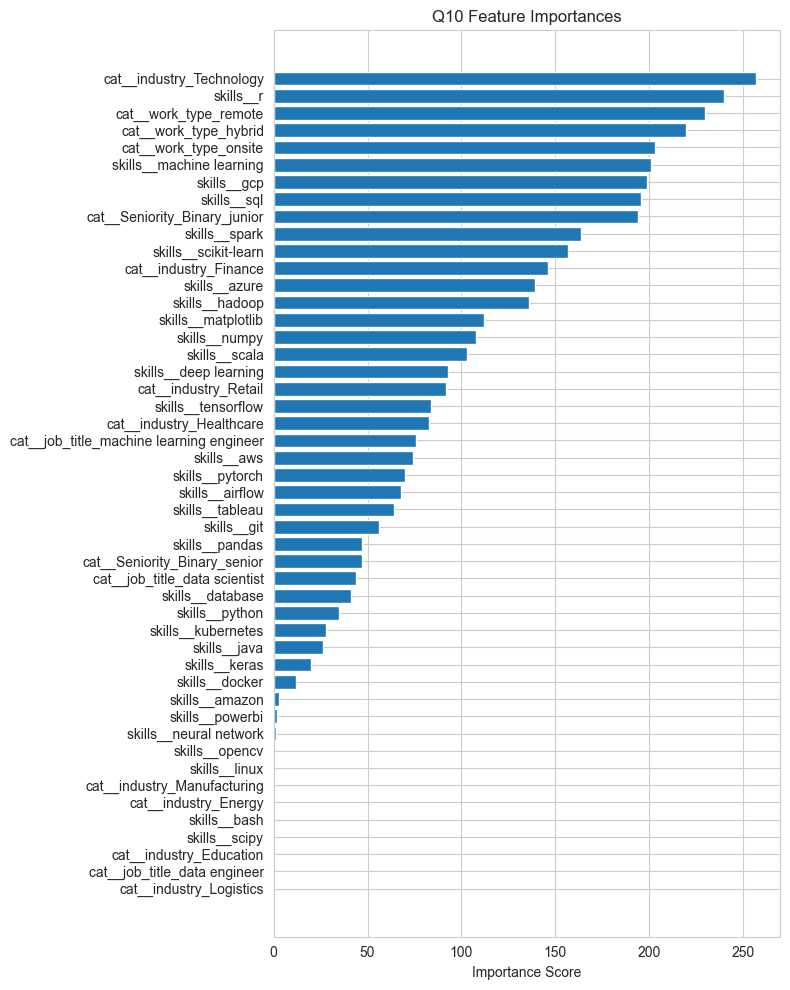

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 401, number of used features: 40
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] St

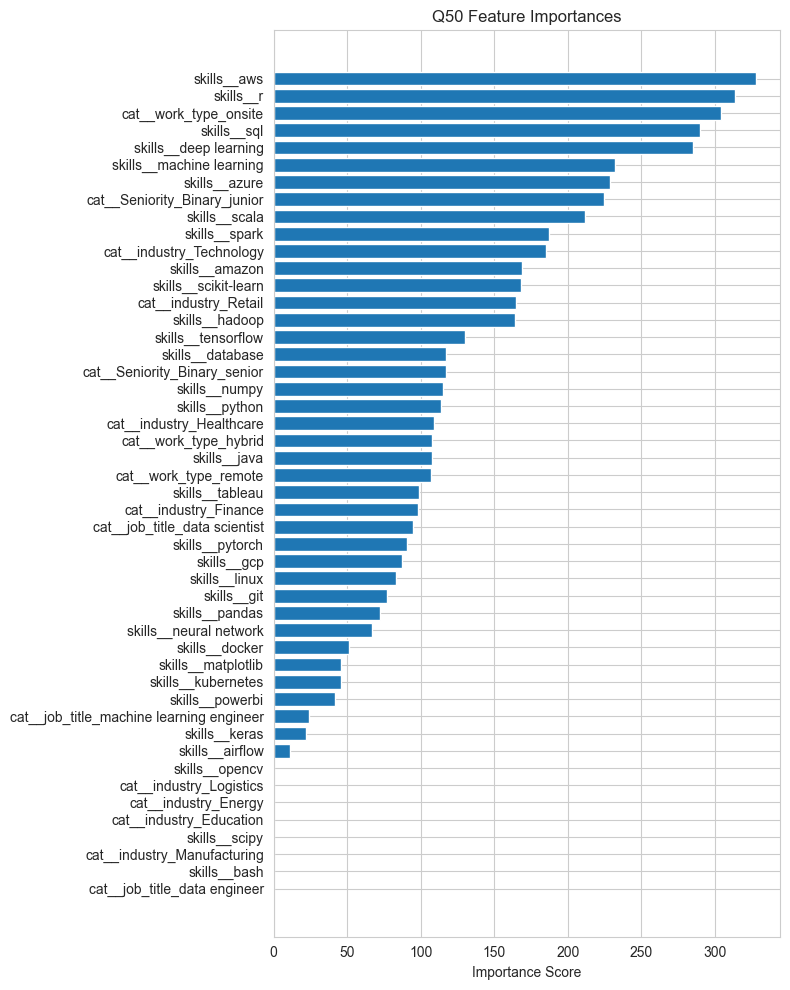

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 401, number of used features: 40
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] St

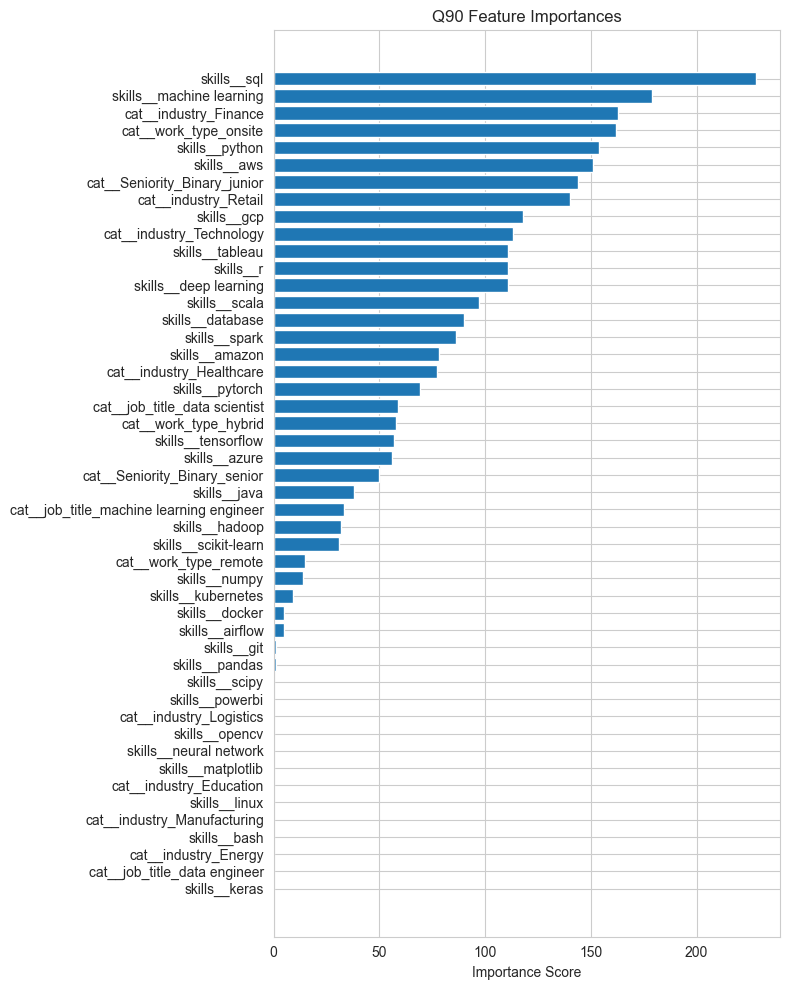

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
80% interval empirical coverage: 0.7619047619047619


In [68]:

# Prepare LightGBM datasets (use preprocessor to transform features)
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()
X_test_df = pd.DataFrame(X_test_trans, columns=feature_names)


# Split training data into train and validation subsets. This will be important for the LightGBM model to properly monitor model performance for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_trans, y_train.values, test_size=0.2, random_state=RANDOM_STATE)

# Train three quantile models (10th, 50th, 90th) or use LightGBM with objective 'quantile'
def train_quantile(q):
    # Split training data into train and validation subsets. This will be important for the LightGBM model to properly monitor model performance for early stopping
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_trans, y_train.values, test_size=0.2, random_state=RANDOM_STATE)
    params = {
        'objective': 'quantile',
        'alpha': q,                      # 0.1, 0.5, or 0.9
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'n_estimators': 1000,            # more rounds, rely on early stopping
        'early_stopping_rounds': 100,    # monitor validation loss
        'max_depth': 6,                  # deeper trees than before
        'num_leaves': 64,                # more leaves to capture structure
        'min_data_in_leaf': 5,           # allow splits with fewer samples
        'min_child_samples': 5,          # override default (20)
        'colsample_bytree': 0.8,         # use more features per tree
        'subsample': 0.9,                # add stochasticity
        'reg_alpha': 0.1,                # light L1 regularization
        'reg_lambda': 0.1,               # light L2 regularization
        'random_state': 69
    }

    model = LGBMRegressor(**params)
    model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=50)])
    return model


q10 = train_quantile(0.1)
importances = q10.feature_importances_

feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': q10.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 10))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.gca().invert_yaxis()
plt.title("Q10 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

q50 = train_quantile(0.5)
importances = q50.feature_importances_

feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': q50.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 10))
plt.barh(feat_df['feature'], feat_df['importance'])
plt.gca().invert_yaxis()
plt.title("Q50 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


q90 = train_quantile(0.9)
importances = q90.feature_importances_

feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': q90.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 10))
plt.barh(feat_df['feature'], feat_df['importance'], )
plt.gca().invert_yaxis()
plt.title("Q90 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Predict logs and convert to original scale
pred10_log = q10.predict(X_test_df)
pred50_log = q50.predict(X_test_df)
pred90_log = q90.predict(X_test_df)
pred10 = np.expm1(pred10_log)
pred50 = np.expm1(pred50_log)
pred90 = np.expm1(pred90_log)



# Evaluate coverage
coverage_80 = np.mean((y_true >= pred10) & (y_true <= pred90))
print("80% interval empirical coverage:", coverage_80)



<h2>Evaluation and Interpretation</h2>

In order to evaluate the performance of our model, we'll recompute MAE and RMSE and look at some basic visualizations of salary predictions (residuals) and how the most important factors influence salary prediction (SHAP values).

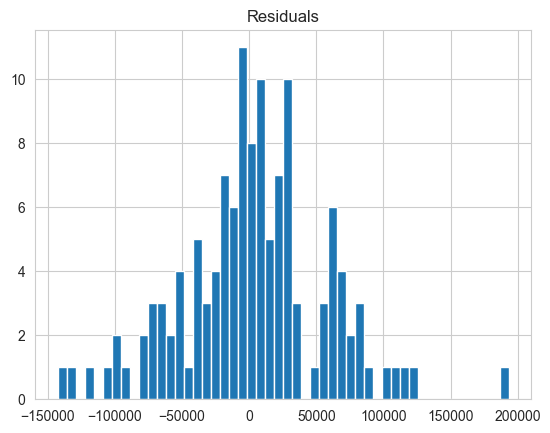

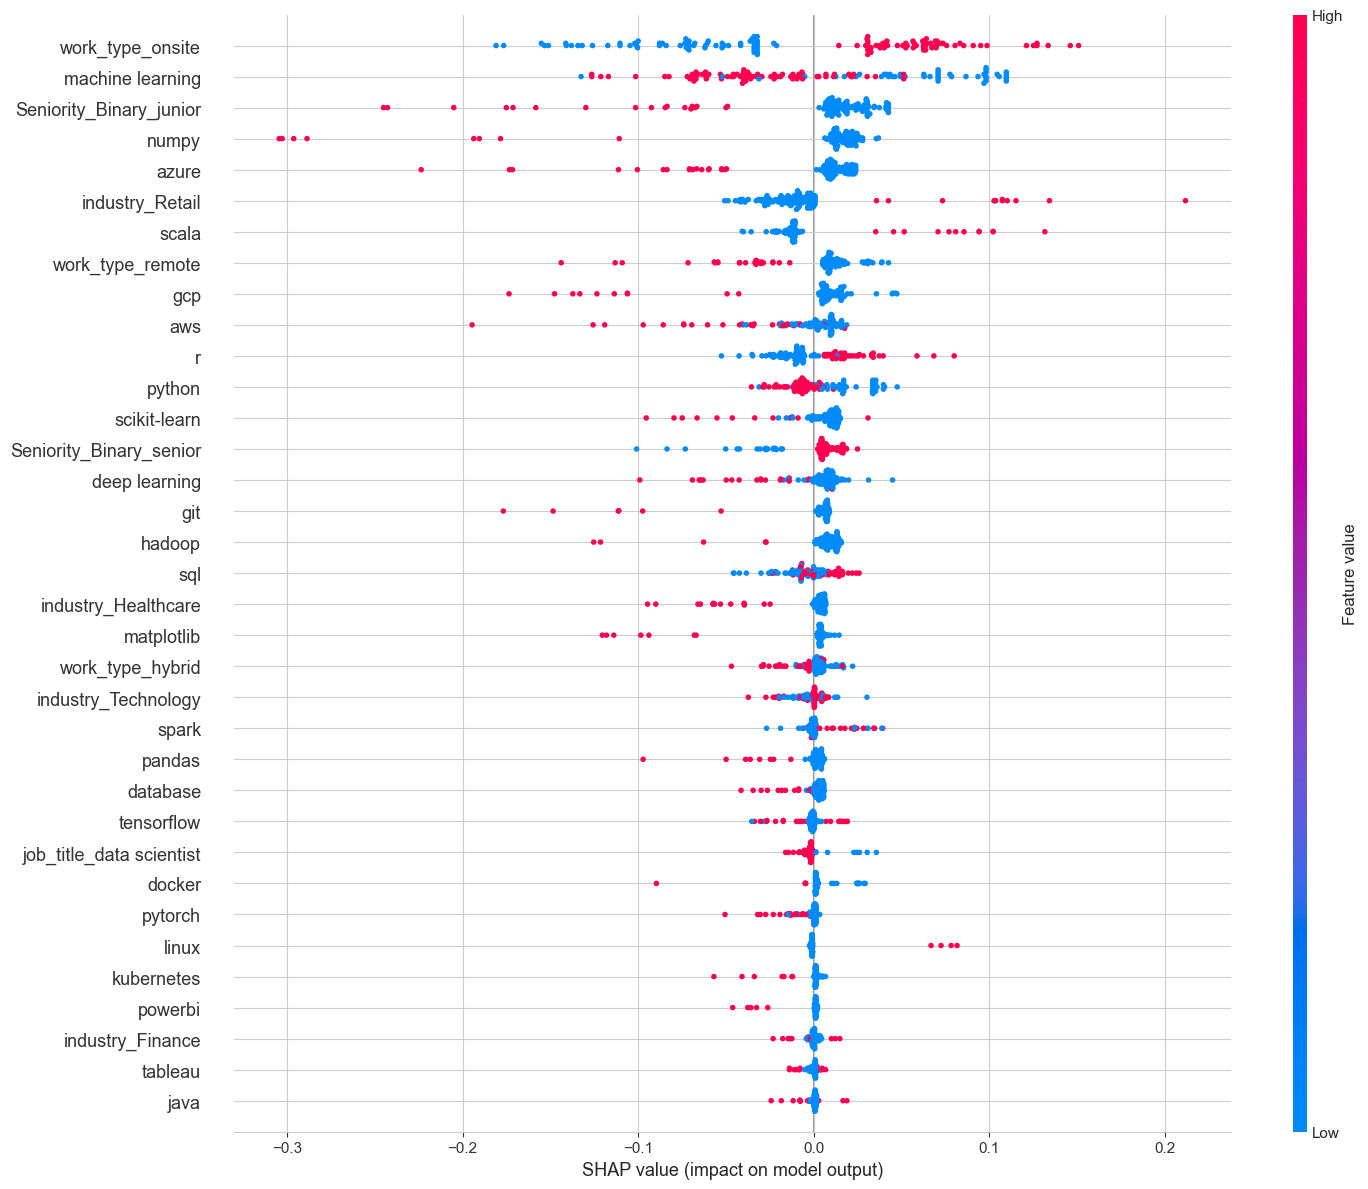

In [69]:
# Residual diagnostics
residuals = y_true - pred50
plt.hist(residuals, bins=50)
plt.title("Residuals")
plt.show()

# SHAP for the median LightGBM model (q50)
explainer = shap.TreeExplainer(q50)
shap_vals = explainer.shap_values(X_test_trans)
shap_dense = shap_vals[0] if isinstance(shap_vals, list) else shap_vals

def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder':
            continue  # skip passthrough or dropped columns

        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
        elif hasattr(transformer, 'get_feature_names'):
            names = transformer.get_feature_names()
        else:
            names = columns  # fallback

        feature_names.extend(names)

    return feature_names

feature_names = get_feature_names(preprocessor)

# For large transformed X, you may sample then plot summary

shap.summary_plot(shap_dense, X_test_trans, feature_names=feature_names, plot_size=(15, 12), max_display=35)


Residuals at q50 show a symmetric distribution centered very near zero, suggesting that predictions are, at least broadly speaking, unbiased across the dataset. The horizontal spread (-150k to +200k) shows that absolute errors in predicted salaries can at times be huge. Comparing this spread to our MAE and RMSE, we understand that some actual salaries would fall significantly outside the range of predicted salaries from our quantile regression model. 

Looking at the violin plot of feature SHAP values, we see some pretty interesting aspects of how the model predicts salaries. A job having or not having work_type = 'onsite' is clearly the most straightforwardly predictive feature of our model, with onsite work positively impacting salaries and non-onsite work negatively impacting predicted salary. Looking at the other work types, we see a reverse, albeit much weaker, pattern for both remote and hybrid work_types. That is, although not as predictive of salary, a job being remote would tend to reduce the predicted salary and a job not being remote would tend to improve the salary. It should be noted here that feature values are either completely positive or completely negative because of how one-hot encoding converts categorical values into binaries. That means that red color on the plot represents the presence of the feature and blue represents its absence.

As mentioned previously, some of the most preditive features of this model's early iterations were actually missing values in the selected criteria (especially blank skills and no listed work_type). These were factored out in the model shown here, but we can still see the influence of jobs/salaries tending not to have certain features associated with them from the mostly negative impact of many skills on predicted salary (e.g. sql, aws, numpy). Conversly in these cases, we see that the absence of those skills is only very modestly improving predicted salary. There may in some cases be more to the influence of these skills on predicted salary, however. My thought is that if you're applying for a data science role and we need to tell you that you should know python and machine learning, you probably shouldn't expect a very high salary. In other instances it may be more telling about the workplace where the role is being sought; if an employer is heavily reliant on matplotlib for visualizations, rather than a more premium (expensive) data vizualization solution, it could be that they do not have the same amount of funding to provide for salaries. Admittedly, that is a bit of a stretch and not easily confirmed by the data itself, but I prefer to provide a diversity of narratives that can explain the spread of values rather than sticking rigidly to what they data tells us on its face.

In [70]:
def pinball_loss(y, q, alpha):
    e = y - q
    return np.mean(np.where(e >= 0, alpha * e, (alpha - 1) * e))

pb_10 = pinball_loss(y_true, pred10, 0.10)
pb_50 = pinball_loss(y_true, pred50, 0.50)
pb_90 = pinball_loss(y_true, pred90, 0.90)
mae_50 = np.mean(np.abs(y_true - pred50))
rmse_50 = np.sqrt(np.mean((y_true - pred50) ** 2))
coverage_80 = np.mean((y_true >= pred10) & (y_true <= pred90))
avg_width = np.mean(pred90 - pred10)
bias_10 = np.mean(y_true - pred10)
bias_50 = np.mean(y_true - pred50)
bias_90 = np.mean(y_true - pred90)

summary = pd.DataFrame([
    {"metric": "pinball_10", "value": pb_10},
    {"metric": "pinball_50", "value": pb_50},
    {"metric": "pinball_90", "value": pb_90},
    {"metric": "MAE_50", "value": mae_50},
    {"metric": "RMSE_50", "value": rmse_50},
    {"metric": "80%_coverage", "value": coverage_80},
    {"metric": "avg_interval_width", "value": avg_width},
    {"metric": "bias_10", "value": bias_10},
    {"metric": "bias_50", "value": bias_50},
    {"metric": "bias_90", "value": bias_90}
])
print(summary.to_string(index=False))
print(f"average q10 prediction: {np.mean(pred10)}")
print(f"average q50 prediction: {np.mean(pred50)}")
print(f"average q90 prediction: {np.mean(pred90)}")

            metric         value
        pinball_10   9227.804800
        pinball_50  20115.223104
        pinball_90   8763.943610
            MAE_50  40230.446209
           RMSE_50  53897.846209
      80%_coverage      0.761905
avg_interval_width 129121.535867
           bias_10  71107.864207
           bias_50   2976.186503
           bias_90 -58013.671660
average q10 prediction: 70261.57626900144
average q50 prediction: 138393.25397347703
average q90 prediction: 199383.11213635406


Here I've computed some statistics to more precisely describe the performance of the model.

We can see that both MAE (40230.44) and RMSE (53897.85) were reduced compared with the baseline model (51239.67 and 64732.60, respectively), though they remain high. This suggest that the LightGBM model more accurately predicts expected salary than the linear model, and with lessened influence from outliers. While this may sound like improvement, the large magnitude of the values should probably temper our excitement a bit. Still, that ~76% of actual salaries fall within the 80% quantile interval is a much stronger result than extremely weak R-squared value from the linear model (-0.009).

Pinball loss values are computed for each quantile. Pinball loss in the weighted absolute error of predictions at a given quantile, with positive and negative residuals weighted differently, allowing us to assess the relative accuracy of our model at each quantile. Lower pinball values indicate a higher degree of accuracy. Here we see that our 90th quantile has the lowest pinball loss, followed by 10th, and finally the median. This means that we have higher confidence in the bounds of a predicted salary range than we do in a predicted median salary based on user's inputs. We also see, however, that our average interval width, or the mean difference in predicted salaries at our upper and lower quantiles, is quite high. In fact it is larger than our mean salary for the dataset overall (mean salary  = 126181.9335812965) and nearly as large as the average of median salary predictions produced by our model (average q50 prediction = 138393.25397347703). This means that while we can have a higher confidence in the range of salaries we might predict for a given candidate, we will also on average be providing a range that is +/- ~50% of the median point prediction. That's doesn't really give the applicant very much new information about what to expect.

Examining bias at our computed quantiles, we see large positive bias at q10, low bias at q50, and large negative bias at q90. The good news here is, as we saw with our residuals plot before, median point predictions are systematically unbiased (if somewhat low confidence). On the other hand, large upper and lower quantile biases tell us that our model systematically underpredicts the low end of actual salaries and also overpredicts the high end of actual salaries. That's not that surprising based on the average interval width discussed earlier. What this tells us is that the model lacks features that accurately explain large and small salaries. 



Text(0, 0.5, 'Actual y')

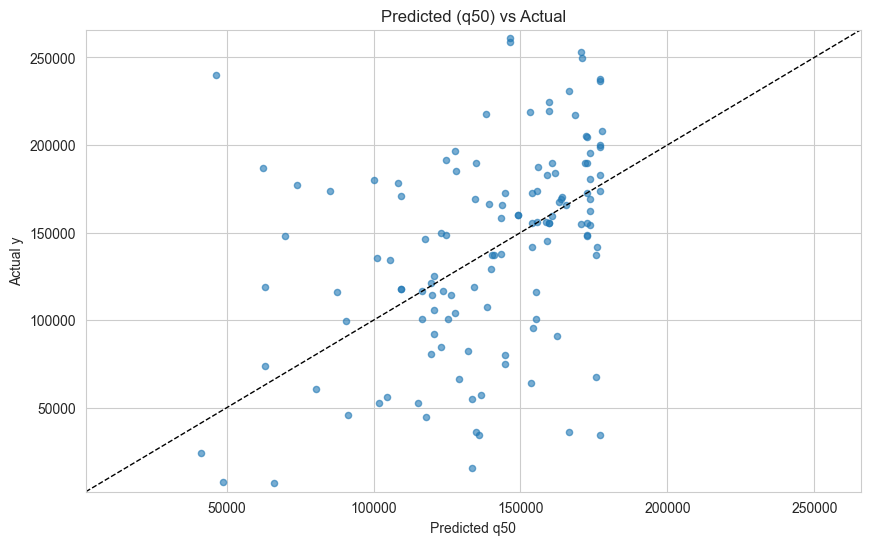

In [71]:
# Predicted vs Actual (median)

fig, axes = plt.subplots(figsize=(10,6))
ax = axes
ax.scatter(pred50, y_true, alpha=0.6, s=20)
lims = [np.nanmin(np.concatenate([pred50, y_true])-5000), np.nanmax(np.concatenate([pred50, y_true])+5000)]
ax.plot(lims, lims, color="k", linestyle="--", linewidth=1)
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_title("Predicted (q50) vs Actual")
ax.set_xlabel("Predicted q50")
ax.set_ylabel("Actual y")


Things are looking pretty cloudy in the space relating predicted q50 salaries with actual salaries.

Text(0, 0.5, 'Interval width')

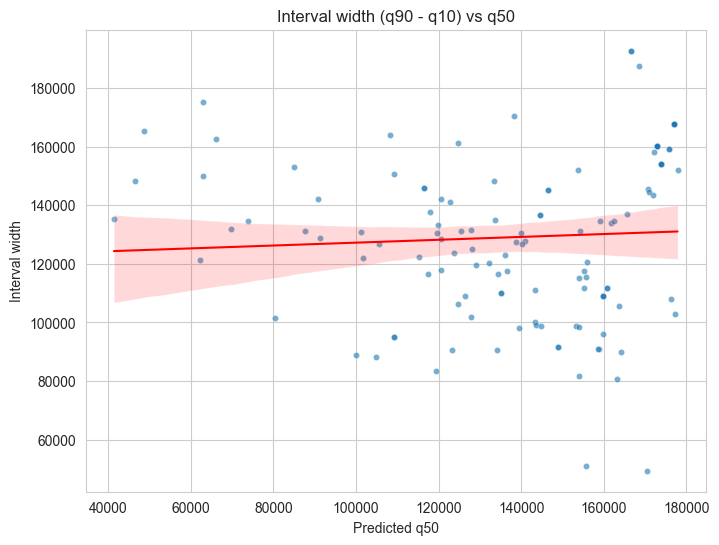

In [73]:
# Interval width vs predicted median
fig, axes = plt.subplots(figsize=(8,6))
ax = axes
interval_width = pred90 - pred10
sns.scatterplot(x=pred50, y=interval_width, alpha=0.6, s=20, ax=ax)
sns.regplot(x=pred50, y=interval_width, scatter=False, ax=ax, color="red", line_kws={"linewidth":1.5})
ax.set_title("Interval width (q90 - q10) vs q50")
ax.set_xlabel("Predicted q50")
ax.set_ylabel("Interval width")

Looking at how interval widths very with predicted q50 we see clear heteroskedastic uncertainty. That is, we see that uncertainty in predicted q50 is not constant across the range of predicted values. The trendline shows a very slight positive trend in interval widths with predicted q50, with slightly higher confidence at higher values of q50 than lower. The most likely explanation for the spread of interval widths seen here is simply extrapolation on a relatively sparse dataset.

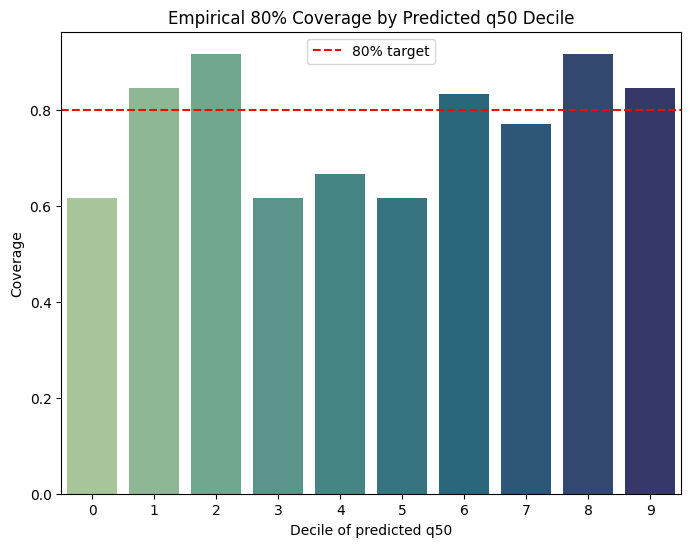

In [31]:
fig, axes = plt.subplots(figsize=(8,6))
ax = axes
df_diag = pd.DataFrame({"y": y_true, "q10": pred10, "q50": pred50, "q90": pred90})
df_diag["decile"] = pd.qcut(df_diag["q50"].rank(method="first"), 10, labels=False)
coverage_by_decile = (
    df_diag.assign(in_interval=lambda df: (df["y"] >= df["q10"]) & (df["y"] <= df["q90"]))
    .groupby("decile", sort=True, observed=True)["in_interval"]
    .mean()
)
sns.barplot(x=coverage_by_decile.index, y=coverage_by_decile.values, palette="crest", hue=coverage_by_decile.index, legend=False, ax=ax)
ax.axhline(0.8, color="red", linestyle="--", label="80% target")
ax.set_title("Empirical 80% Coverage by Predicted q50 Decile")
ax.set_xlabel("Decile of predicted q50")
ax.set_ylabel("Coverage")
ax.legend()

Here we see how q90-q10 coverage varies with predicted q50 decile, with some deciles falling significantly under target. This is further evidence of heteroskedasticity in the model. Again, the mostly likely cause for this would be that our model lacks features or interactions that adequately explain variance in predicted salaries.

In [74]:
# Additional diagnostics
print("\nAdditional diagnostics:")
print(f"  n samples: {len(y_true)}")
print(f"  prop where y < q10 : {np.mean(y_true < pred10):.3f}")
print(f"  prop where y > q90 : {np.mean(y_true > pred90):.3f}")
print(f"  median interval width: {np.median(interval_width):.3f}")
print(f"  10th percentile interval width: {np.percentile(interval_width,10):.3f}")
print(f"  90th percentile interval width: {np.percentile(interval_width,90):.3f}")


Additional diagnostics:
  n samples: 126
  prop where y < q10 : 0.111
  prop where y > q90 : 0.127
  median interval width: 130816.895
  10th percentile interval width: 91693.150
  90th percentile interval width: 163360.554


<h2>Minimal Streamlit Demo</h2>

In [ ]:
# Save this as DsJobs_app.py and run: streamlit run DSJobs_app.py
import streamlit as st
import joblib
import numpy as np
import pandas as pd

df_filtered = pd.read_csv("C:\RepoClones\PythonPractice\DSJobs\df_filtereed.csv")
title_list = df_filtered['job_title'].dropna().unique()
industries = df_filtered['industry'].dropna().unique()

def skill_tokenizer(text):
    return [t for t in text.split('|') if t.strip()]

skill_list = []
for skills in df_filtered['skills_parsed'].dropna():
    tokens = skill_tokenizer(skills)
    for t in tokens:
        skill_list.append(t.strip(" []'\"").lower())
    

skill_list = list(set(skill_list))
    


pipeline = joblib.load(r"C:\RepoClones\PythonPractice\DSJobs\models\baseline_ridge_pipeline.joblib")
# Load or wrap quantile models (q10,q50,q90) - save and load similarly if trained separately

st.title("Salary range predictor (demo)")

seniority = st.selectbox("Experience level", ["junior", "senior"])
skills = st.multiselect("Skills", skill_list, default=["python", "sql", "machine learning"])
job_title = st.selectbox("Job title", title_list)
industry = st.selectbox("Industry", industries)
work_type = st.selectbox("Work type", ["onsite", "hybrid", "remote"])


if st.button("Predict"):
    # Preprocess single input into DataFrame row
    row = pd.DataFrame([{
        'Seniority_Binary': seniority,
        'skills_parsed': " | ".join(skills),
        'job_title': job_title,
        'industry': industry,
        'work_type': work_type
    }])
    pred_log = pipeline.predict(row)[0]
    median = np.expm1(pred_log)
    # For intervals, use quantile models; here we show a simple +/- heuristic
    lb = max(0, median * 0.8)
    ub = median * 1.25
    st.write(f"Predicted salary median: €{median:,.0f}")
    st.write(f"Estimated range: €{lb:,.0f} — €{ub:,.0f}")
    st.info("This demo uses a baseline model; train quantile LightGBM models for calibrated intervals.")



<center><h2><strong>Conclusions</strong></h2></center>

This cell will contain takeaways. It might even make sense to have all of the editorial comments from the EDA section moved into here...